
SRC .a.,aab,bc --> TARGET ba,a,b,ca
target
dup genes --> multiplicity
OrderedDict('a' => 3, 'b' => 2)

target map
[1, 1]

source
dup genes --> multiplicity
OrderedDict('a' => 3, 'b' => 2)

source maps
[6, 1]
[1, 1]
[4, 2]
[3, 2]
[5, 1]
[6, 2]
[1, 2]
[3, 1]

deduplication
[deduplicated] .y.,nab,ic --> ba,n,i,cy 4 [6, 1]
[deduplicated] .a.,nyb,ic --> ba,n,i,cy 6 [1, 1]
[deduplicated] .n.,yai,bc --> ba,n,i,cy 4 [4, 2]
[deduplicated] .n.,ayi,bc --> ba,n,i,cy 4 [3, 2]
[deduplicated] .y.,anb,ic --> ba,n,i,cy 4 [5, 1]
[deduplicated] .y.,nai,bc --> ba,n,i,cy 6 [6, 2]
[deduplicated] .a.,nyi,bc --> ba,n,i,cy 6 [1, 2]
[deduplicated] .n.,ayb,ic --> ba,n,i,cy 4 [3, 1]

SRC .a.,aab,bc --> TARGET ba,a,b,ca
target
dup genes --> multiplicity
OrderedDict('a' => 3, 'b' => 2)

target map
[1, 1]

source
dup genes --> multiplicity
OrderedDict('a' => 3, 'b' => 2)

source maps
[2, 1]
[1, 1]
[5, 1]
[5, 2]
[6, 2]
[4, 2]
[2, 2]
[6, 1]

deduplication
[deduplicated] .a.,dfb,oc --> ba,f,o,cd 6 [2, 1]
[deduplicated

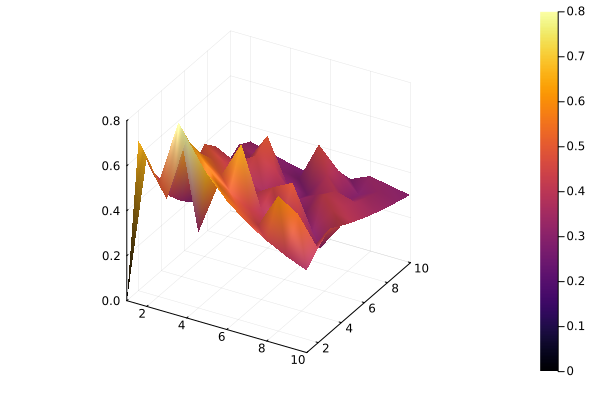

In [1]:
using Plots

using NBInclude
@nbinclude("randommap.ipynb")
@nbinclude("testing_maps.ipynb")


In [2]:
function convert_maptodcjdist_to_converse(map_to_dedupstr_dcjdist::Dict{Vector{Int}, Tuple{String, Int}})
    dcjdist_to_map = Dict{Int, Vector{Vector{Int}}}()

    for (map, tuple) in map_to_dedupstr_dcjdist
        dcjdist = tuple[2]

        if dcjdist in keys(dcjdist_to_map)
            push!(dcjdist_to_map[dcjdist], map)
        else 
            dcjdist_to_map[dcjdist] = [map]
        end 
    end 

    return dcjdist_to_map
end 

convert_maptodcjdist_to_converse (generic function with 1 method)

In [3]:
function permlexrank(n::Int, perm::Vector{Char})
    r = 1
    p = perm 

    for j in 1:n
        r += (p[j]-1) * (factorial(n-j))
        for i in j+1:n
            if p[i] > p[j]
                p[i] = p[i]-1
            end 
        end 
    end 
    return r 
end 

n = 4 
perm = ['a','b', 'c', 'd']

permlexrank(n, perm)

LoadError: MethodError: no method matching *(::Char, ::Int64)

[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m)
[0m[90m   @[39m [90mBase[39m [90m[4moperators.jl:587[24m[39m
[0m  *([91m::Complex{Bool}[39m, ::Real)
[0m[90m   @[39m [90mBase[39m [90m[4mcomplex.jl:328[24m[39m
[0m  *([91m::Missing[39m, ::Number)
[0m[90m   @[39m [90mBase[39m [90m[4mmissing.jl:123[24m[39m
[0m  ...


In [ ]:
function find_neighbor(idxs_of_neighbors::Set{Int}, ::Vector{Int}, S_dupchar_to_multiplicity::OrderedDict{Char, Int}, new_neighbor_defn::Bool)
    i = rand(idxs_of_neighbors)
    pop!(idxs_of_neighbors, i)

    neighbor = deepcopy(map_to_explore)
    neighbor[i] += 1    

    # mod(multiplicity!)
    multiplicity = S_dupchar_to_multiplicity[collect(keys(S_dupchar_to_multiplicity))[i]]
    if neighbor[i] > factorial(multiplicity) 
        neighbor[i] = 1 
    end 

    return neighbor
end 

In [ ]:
# given string S and two maps m and v, v = neighbor(m) if 
    # for a replicated char α at idx i in the maps, v[i] = (m[i] + 1) (mod occ(α,S)!)  
    # all other chars (idx e) are mapped the same way v[e] = m[e]
function find_neighbors(map_to_explore::Vector{Int}, max_neighbors_to_explore::Int, map_to_dedupstr_dcjdist::Dict{Vector{Int}, Tuple{String, Int}}, S_dupchar_to_multiplicity::OrderedDict{Char, Int}, using_new_neigh_defn::Bool)  
    neighbors = Set{Vector{Int}}()

    if using_new_neigh_defn
        

    else # old definition of neighbors given in paper  
        idxs_of_neighbors = Set(range(1, length(map_to_explore)))  # index of the character in a map that's incremented 

        # cap neighbors to explore 
        max_possible_neighbors = length(map_to_explore)
        if max_neighbors_to_explore > max_possible_neighbors 
            max_neighbors_to_explore = max_possible_neighbors  
        end 

         neighbor = map_to_explore
        for i in 1:max_neighbors_to_explore
            while (neighbor in neighbors) || (neighbor in keys(map_to_dedupstr_dcjdist))
                if length(idxs_of_neighbors) == 0
                    return collect(neighbors)
                end

                neighbor = find_neighbor(idxs_of_neighbors, map_to_explore, S_dupchar_to_multiplicity, new_neighbor_defn)
            end 

            push!(neighbors, neighbor)
        end 
        return collect(neighbors) 
    end    
end 


function insert_new_map_into_documentation(neighbor::Vector{Int}, dcjdist::Int, dedup_genome::String, map_to_dedupstr_dcjdist::Dict{Vector{Int}}, dcjdist_to_map::Dict{Int, Vector{Vector{Int}}}, sorted_dists::Vector{Int})
    if neighbor in keys(map_to_dedupstr_dcjdist) 
        throw(ArgumentError("uhhhh generated a repeat map"))
    end

    map_to_dedupstr_dcjdist[neighbor] = (dedup_genome, dcjdist)
    
    if dcjdist in keys(dcjdist_to_map)
        # printstyled(dcjdist_to_map, color=:blue)
        push!(dcjdist_to_map[dcjdist], neighbor)
        # printstyled(dcjdist_to_map, color=:blue)
    else 
        dcjdist_to_map[dcjdist] = [neighbor]
    end 

    if dcjdist ∉ sorted_dists
        idx = searchsortedfirst(sorted_dists, dcjdist)
        insert!(sorted_dists, idx, dcjdist)    
    end 
end 

In [ ]:
# local search heuristic

# total_maps = total number of maps to be created 
# rand_maps = number of maps randomly generated 
# max_neighbors = max number of neighbors explored in each local search
function localsearch(S::String, P::String, total_maps::Int, rand_maps::Int, max_neighbors::Int, mode::String, dupchar_to_unique_chars::OrderedDict{Char, Vector{Char}}, new_neighbor_defn::Bool)
     m = setmode(mode)

    printstyled("SRC " * S * " --> TARGET " * P * "\n", color=:cyan)

    # create arbitrary map for P, a set of random maps S_M, rank maps using estimator algo 
    _, P_dedup, map_to_dedupstr_dcjdist, S_dupchar_to_multiplicity = generate_random_maps_and_calc_distances(S, P, rand_maps, dupchar_to_unique_chars, m)
    num_generated_maps = rand_maps
    explored_maps = Set{Vector{Int}}()
    
    if m >= 1
        print("random maps: ", keys(map_to_dedupstr_dcjdist), "\n")
    end 
    og_rm_to_dedupstr_dcjdist = deepcopy(map_to_dedupstr_dcjdist)
   
    # best map and corresponding details (returned at the end)
    global_min_map = Vector{Int}() 
    global_min_dcj = Inf
    global_min_dedupstr = ""

    # cap maps explored 
    total_possible_maps = 0
    for (_, mult) in S_dupchar_to_multiplicity
        total_possible_maps += factorial(mult)
    end 
    if total_maps > total_possible_maps 
        total_maps = total_possible_maps 
        if m >= 1
            println("WARNING: capping total maps at ", total_maps)
        end 
    end 
    
    dcj_dist_to_map = convert_maptodcjdist_to_converse(map_to_dedupstr_dcjdist)
    sorted_dists = sort(collect(keys(dcj_dist_to_map)))
    
    # until 'total_maps' maps are generated
    while total_maps != num_generated_maps
        # select best not yet explored map 
        smallest_dcj_dist = sorted_dists[1]
        maps = dcj_dist_to_map[smallest_dcj_dist]
        
        map_smallestd = popfirst!(maps)
        if m >= 1
            println("\ngenerated ", num_generated_maps, "/", total_maps)
            println("exploring neighborhood of ", map_smallestd)
        end 
        if isempty(maps)
            delete!(dcj_dist_to_map, smallest_dcj_dist)
            popfirst!(sorted_dists)
        end 
    
        # cap neighbors 
        if max_neighbors > total_maps - num_generated_maps 
            max_neighbors = total_maps - num_generated_maps    
        end 
        # searches up to 'max_neighbors' neighbor maps
        neighbors = find_neighbors(map_smallestd, max_neighbors, map_to_dedupstr_dcjdist, S_dupchar_to_multiplicity, new_neighbor_defn)
        
        # insert neighbors into documentation 
        if m >= 1
            println("neighbors explored: ")
        end 
        for n in neighbors 
            s_dedup = deduplicate_genome(n, S, S_dupchar_to_multiplicity, dupchar_to_unique_chars)
            d = calculate_distance(P_dedup, s_dedup, "none")
            insert_new_map_into_documentation(n, d, s_dedup, map_to_dedupstr_dcjdist, dcj_dist_to_map, sorted_dists)
            if m >= 1
                println("     ", n, " dcj dist=", d)
            end 

            if d < global_min_dcj
                global_min_map  = n
                global_min_dcj =  map_to_dedupstr_dcjdist[global_min_map][2]
                global_min_dedupstr = map_to_dedupstr_dcjdist[global_min_map][1]

                if m >= 1
                    print("\\\\\\\\found a min dcj mapping ", global_min_map, " with distance ", global_min_dcj, "   ")
                    println(P_dedup, " --> ", global_min_dedupstr)
                end 
            end 
        end 
            
        # no repeat exploration 
        num_generated_maps += length(neighbors)
        push!(explored_maps, map_smallestd)
    end

    # return map that returns the shortest DCJ dist 
    return global_min_dcj, global_min_map, global_min_dedupstr, map_to_dedupstr_dcjdist, og_rm_to_dedupstr_dcjdist
end 


In [ ]:
n = 5
x = 3

target = generate_target_with_xdup(n, x)
src = scramble_target(target)

# src = ".a.,aab,bc"  
# target = "ba,a,b,ca"

total_maps = 10
rand_maps = 3
max_neighbors = 5

mode = "info"
dupchar_to_unique_chars = OrderedDict{Char, Vector{Char}}()

global_min_dcj, global_min_map, global_min_dedupstr, map_to_dedupstr_dcjdist, og_rm = localsearch(src, target, total_maps, rand_maps, max_neighbors, mode, dupchar_to_unique_chars, false)

In [ ]:
# Define a function to subtract one list from another considering duplicates
function list_difference_with_duplicates(list1, list2)
    # Make a copy of list1 to avoid modifying the original
    result = copy(list1)
    
    # Iterate through elements of list2
    for elem in list2
        # Find the index of the element in result, if it exists
        index = findfirst(x -> x == elem, result)
        if index !== nothing
            # Remove the element at the found index
            deleteat!(result, index)
        end
    end
    
    return result
end

# # Define two lists
# list1 = [1, 2, 2, 3, 4, 5, 5, 5]
# list2 = [2, 5]

# # Subtract list2 from list1 considering duplicates
# result = list_difference_with_duplicates(list1, list2)

In [ ]:
rm_dcj_dists = [tupl[2] for tupl in values(og_rm)]
dcjdists = [tupl[2] for tupl in values(map_to_dedupstr_dcjdist)]

# dcjdists = list_difference_with_duplicates(dcjdists, rm_dcj_dists)

bins_range = range(0, maximum(dcjdists)+1, maximum(dcjdists)+1)
histogram(dcjdists, bins=bins_range, title="local search freq distribution", label="local search maps", xlabel="DCJ Dist", ylabel="Frequency", alpha=0.5, color=:blue)
histogram!(rm_dcj_dists, bins=bins_range, label="random maps", alpha=0.5, color=:green)

In [ ]:
# Define the original list
original_list = ['b', 'a', 'c']

# Get the lexicographical order (permutation of indices)
lexicographical_order = sortperm(original_list)

# Sort the original list according to the lexicographical order
sorted_list = original_list[lexicographical_order]

println("Original list: ", original_list)
println("Lexicographical order (indices): ", lexicographical_order)
# println("Sorted list according to lexicographical order: ", sorted_list)
